In [1]:
#IMPORTS
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os
from PIL import Image

import wandb
wandb.login(key='fbe9062d8afc2237e9c82b76146a6be8f5683c2f')
wandb.init(project='3d_cnn_project', entity='yeneirvine')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yeneirvine (detecting-respiratory-pattern). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/yeneirvine/.netrc
wandb: Currently logged in as: yeneirvine. Use `wandb login --relogin` to force relogin


In [2]:
class BreathingDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.samples = []

        for label in ['Hold-Breath', 'Relaxed']:
            label_path = os.path.join(directory, label)
            for subject_path in os.listdir(label_path):
                subject_full_path = os.path.join(label_path, subject_path)
                if os.path.isdir(subject_full_path):  # Check if it's a directory
                    images = sorted([img for img in os.listdir(subject_full_path) if img.endswith('.jpg')], key=lambda x: int(x.split('.')[0]))
                    image_paths = [os.path.join(subject_full_path, img) for img in images]
                    self.samples.append((image_paths, 0 if label == 'Hold-Breath' else 1))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        images_path, label = self.samples[idx]
        images = [Image.open(img_path) for img_path in images_path]
        if self.transform:
            images = [self.transform(image) for image in images]
        images_stack = torch.stack(images)
        return images_stack, label


In [3]:
# Define transform
# 224, 224 is probably wrong, but just a place holder for now.

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
# Initialize  datasets
train_dataset = BreathingDataset('/Users/yeneirvine/Desktop/Capstone/Data/Training', transform=transform)
val_dataset = BreathingDataset('/Users/yeneirvine/Desktop/Capstone/Data/Validation', transform=transform)
test_dataset = BreathingDataset('/Users/yeneirvine/Desktop/Capstone/Data/Test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # No shuffle for testing=

torch.Size([1, 250, 3, 224, 224])
torch.Size([250, 3, 224, 224])


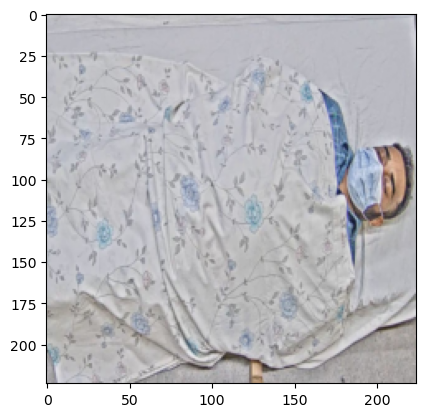

Label: Hold-Breath


In [5]:
import matplotlib.pyplot as plt

# Function to show an image
def imshow(img, index=0):  # Add an index parameter to select which image to show
    # Select a single image from the batch
    single_image = img[index].numpy().transpose((1, 2, 0))  # Adjust for the selected image
    plt.imshow(single_image)
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))
print(images.shape)  # To confirm the shape of the entire batch

# Since your DataLoader's batch size seems to imply a sequence or a large set, 
# let's just take the first image of the first batch to simplify
single_image = images[0]  # This selects the first image from the batch
print(single_image.shape)  # This should print torch.Size([3, 224, 224])

# Show the image and print its label
imshow(single_image,100)  # Display the selected single image
label = 'Hold-Breath' if labels[0] == 0 else 'Relaxed'
print('Label:', label)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Basic3DCNN(nn.Module):
    def __init__(self):
        super(Basic3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1)
        # Adjust the size below based on your input dimensions after flattening
        self.fc1 = nn.Linear(32 * 56 * 56 * 62, 512)  # Example size, adjust accordingly
        self.fc2 = nn.Linear(512, 2)  # Assuming 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56 * 62)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
import torch.optim as optim

# Instantiate the model
model = Basic3DCNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 5

#Log the parameters (this is strictly for logging to wandb, it doesn't change anything in the model)
wandb.config = {
  "learning_rate": 0.001,
  "epochs": num_epochs,
  "batch_size": 1
}
wandb.watch(model, log='all')

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        inputs = inputs.permute(0, 2, 1, 3, 4)  # Adjust dimensions to [batch_size, channels, depth, height, width]

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        # Log after every batch
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss:.3f}')
        wandb.log({"train_loss": running_loss})
        running_loss = 0.0  # Reset running loss if you want to log individual batch loss

print('Finished Training')


[1, 1] loss: 0.730
[1, 2] loss: 2003.238
[2, 1] loss: 0.000
[2, 2] loss: 8.474
[3, 1] loss: 200.533
[3, 2] loss: 0.000
[4, 1] loss: 101.855
[4, 2] loss: 0.000
[5, 1] loss: 22.114
[5, 2] loss: 0.003
Finished Training


In [8]:
# Validation phase
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
val_corrects = 0

with torch.no_grad():  # No need to track gradients for validation
    for inputs, labels in val_loader:
        inputs = inputs.permute(0, 2, 1, 3, 4)  # Adjust dimensions
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        val_corrects += torch.sum(preds == labels.data)


val_loss = val_loss / len(val_loader)
val_accuracy = val_corrects.double() / len(val_loader.dataset)
wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Validation Loss: 0.6991, Validation Accuracy: 0.5000
